### P4.1 Symulacja ruchu kulek na siatce sprężynowej

Rozważyć ruch kulek zamieszczonych na siatce sprężynowej (2D lub 3D).

- Utworzyć animację kulek umieszczonych na siatce.
- Rozważyć różne współczynniki oporu r
- Rozważyć dodatkową siłę grawitacji
- Rozważyć ramę siatki rozmiaru n x m

$m_i x_i'' = \sum_{j} \vec{F}_{i,j} + \vec{G}_{i}$

gdzie

$\vec{F}_{i,j}=\frac{(\vec{x}_{j}-\vec{x}_{i})}{d_{i,j}}\cdot(d_{i,j}-l)\cdot k$

$\vec{G}_{i}=-r\cdot ||\vec{x}_i'||^{\alpha}_2 \cdot \frac{\vec{x}_i'}{||\vec{x}_i'||_2}$

$d_{i,j} = ||\vec{x}_i-\vec{x}_j||_2$  –  odległość kulek

$l$  –  długość sprężynek w spoczynku

oraz $\alpha$ = 2, 1

In [145]:
%matplotlib inline
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def L2norm(val):
    return (val[0]**2+val[1]**2)**0.5

def getNeighbours(i,j,x,l):
    neighbours = []
    if i-1>=0:
        neighbours.append(x[i-1,j])
    else:
        neighbours.append(np.array([0.,l*(j+1)], np.float64))
    if i+1<x.shape[0]:
        neighbours.append(x[i+1,j])
    else:
        neighbours.append(np.array([l*(x.shape[0]+1),l*(j+1)], np.float64))
    if j-1>=0:
        neighbours.append(x[i,j-1])
    else:
        neighbours.append(np.array([l*(i+1),0.], np.float64))
    if j+1<x.shape[1]:
        neighbours.append(x[i,j+1])
    else:
        neighbours.append(np.array([l*(i+1),l*(x.shape[1]+1)], np.float64))
    return neighbours
        
# sila F dla kulki (i,j)
def F(i, j, x, k, l):
    f = np.array([0,0], np.float64)
    x_ij = x[i,j]
    
    for x_n in getNeighbours(i,j,x,l):
        d = L2norm(x_ij-x_n)
        f += ((x_n - x_ij)/d)*(d-l)*k
    return f

# sila G dla kulki (i,j)
def G(i, j, xp, r, alpha):
    xp_ij = xp[i,j]
    if L2norm(xp_ij) == 0.:
        return np.array([0, 0], np.float64)
    #print xp_ij
    g = (-r) * (L2norm(xp_ij)**alpha) * (xp_ij/L2norm(xp_ij))
    return g

In [153]:
def euler2_hybrid_vec_xy(k, l, m, r, alpha, x0, xp0, rng, h):
    (N, M, two) = x0.shape
    t0, tn = rng
    
    t = np.arange(t0,tn,h)
    x, xp = np.zeros((N, M, len(t), 2), np.float64), np.zeros((N, M, len(t), 2), np.float64)
    x[:,:, 0], xp[:,:, 0] = x0, xp0
    
    for ti in range(1, len(t)):
        for i in range(N):
             for j in range(M):
                fi = (F(i,j,x[:,:,ti-1],k,l)+G(i,j,xp[:,:,ti-1],r,alpha))/m[i,j]
                #print F(i,j,x[:,:,ti-1],k,l)
                xp[i,j,ti] = xp[i,j,ti-1] + h*fi
                x[i,j,ti] =  x[i,j,ti-1] + h * xp[i,j,ti]
    return t, x, xp

In [240]:
r = 1
alpha = 1
k = 10
l = 0.2

m = np.array([[5, 1, 1],[1, 1, 1],[1, 1, 1]], np.float64)
x0 = np.array(
    [
        [[0.2, 0.2], [0.2, 0.4], [0.2, 0.6]],
        [[0.4, 0.2], [0.4, 0.4], [0.4, 0.6]],
        [[0.6, 0.2], [0.6, 0.4], [0.6, 0.6]]
    ], np.float64)
xp0 = np.zeros_like(x0)
rng = (0,10)
h = 1/60.



(3, 3, 600, 2) (600,)


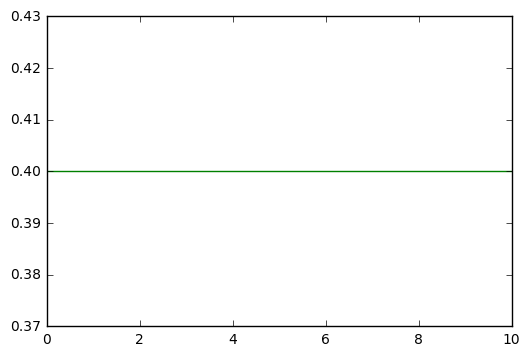

In [241]:
t, x, xp = euler2_hybrid_vec_xy(k, l, m, r, alpha, x0, xp0, rng, h)

#print x
print x.shape, t.shape
plt.plot(t, x[1,0,:,0], 'g')
plt.show()

In [242]:
import cv2
import time

def render_balls(pos, r, l, shape):
    img = np.ones(shape)*[32,40,48]
    (N, M, two) = pos.shape
    for i in range(N):
        for j in range(M):
            center = (int(pos[i,j,0]), int(pos[i,j,1]))
            neighbours = getNeighbours(i,j,pos,l)
            for pos_n in neighbours:
                # color in order to tension
                tension = (l-abs(L2norm(np.array(center)-np.array(pos_n))))*(255./l)
                color = [
                    128+np.clip(-tension,-127,127),
                    128+np.clip(-tension,-127,127),
                    128+np.clip(tension,-127,127)
                ]
                cv2.line(img, center, (int(pos_n[0]), int(pos_n[1])), color, 2)
    
    for i in range(N):
        for j in range(M):
            center = (int(pos[i,j,0]), int(pos[i,j,1]))
            cv2.circle(img, center, int(r[i,j]), [82,16,213], -1)
            cv2.circle(img, (center[0]+int(r[i,j]/3),center[1]-int(r[i,j]/3)), int(r[i,j])/3, [235,240,245], -1)
    return img

def balls_animation(t, x, m, l, max_size):
    (N, M, _, _) = x.shape
    if M>N:
        frame_size = (max_size, int(((N+1.)/(M+1.))*max_size))
        scale = max_size/(l*(M+1))
    else:
        frame_size = (int(((M+1.)/(N+1.))*max_size), max_size)
        scale = max_size/(l*(N+1))
    
    shape = (frame_size[1], frame_size[0], 3)
    video = cv2.VideoWriter(
        'output/v_'+str(time.time())+'.avi',
        cv2.VideoWriter_fourcc(*'MJPG'),
        len(t)//t[-1],frame_size)
    
    r = m/np.max(m)
    r = (r**0.5)*14
    for i in range(len(t)):
        frame = render_balls(x[:,:,i]*scale, r, l*scale, shape)
        video.write(frame.astype(np.uint8))
        
    video.release()

balls_animation(t, x, m, l, 800)